(24, 200)


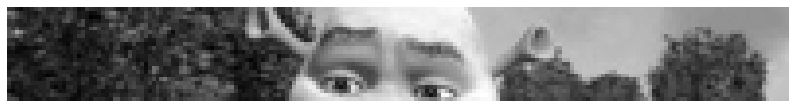

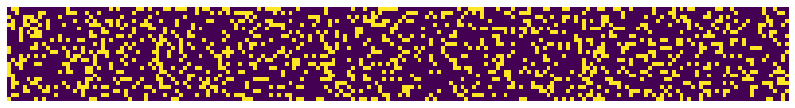

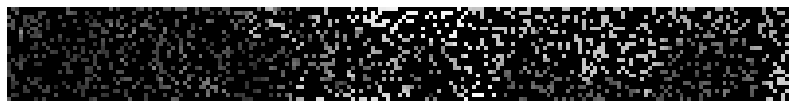

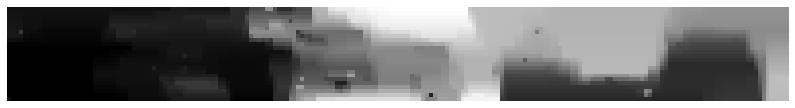

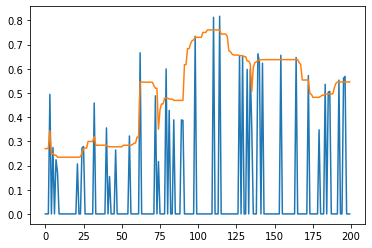

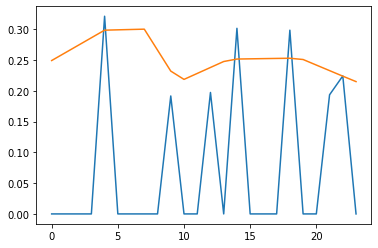

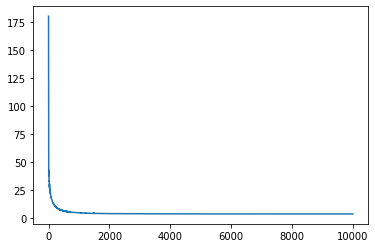

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import chdir
chdir("../Piecewise Constant Denoising/");
%run "../Piecewise Constant Denoising/Khalid_Chambolle_Pock_LinearAndConstant.ipynb"
chdir("../EarthEngine");

In [2]:
df = pd.read_csv("Lhasa/Lhasa_Data-CC-80.csv", index_col=0);
df["SENSING_TIME"] = df["SENSING_TIME"].map(pd.Timestamp);
df_t1 = df[df["SENSING_TIME"]=="2013-04-02"]
df_t2 = df[df["SENSING_TIME"]=="2013-04-28"]
# df = df[(df["ID"] == 1) | (df["ID"] == 2)];

tiles = df["Tile_ID"].unique();
tiles.sort();
tiles.shape

(1944,)

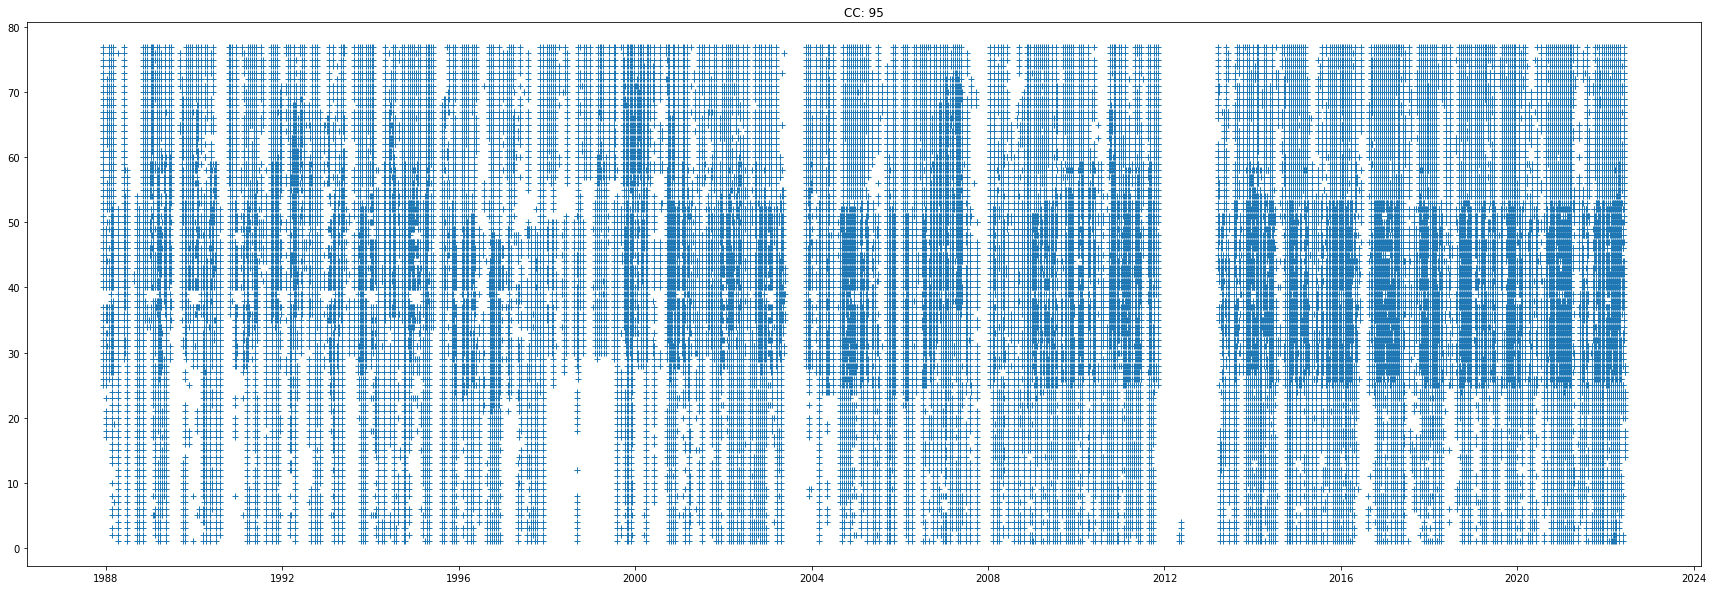

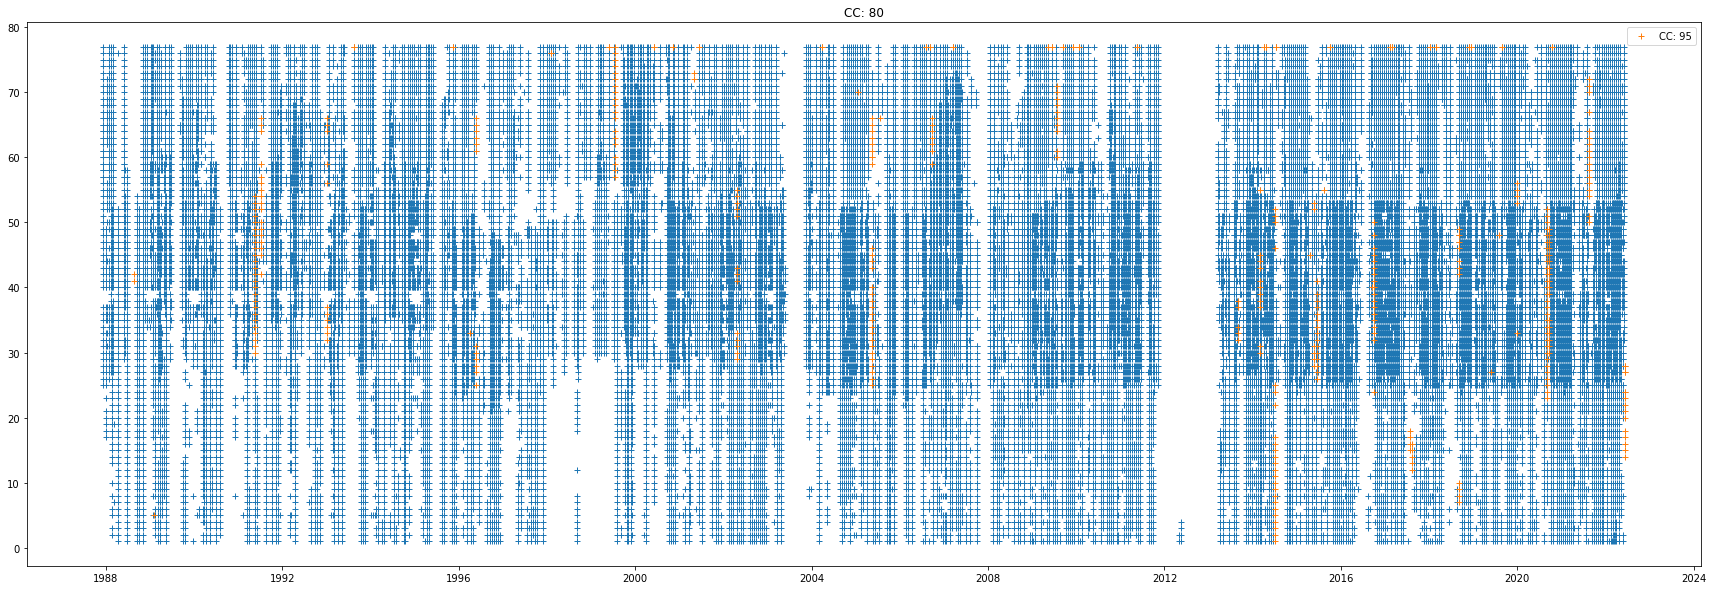

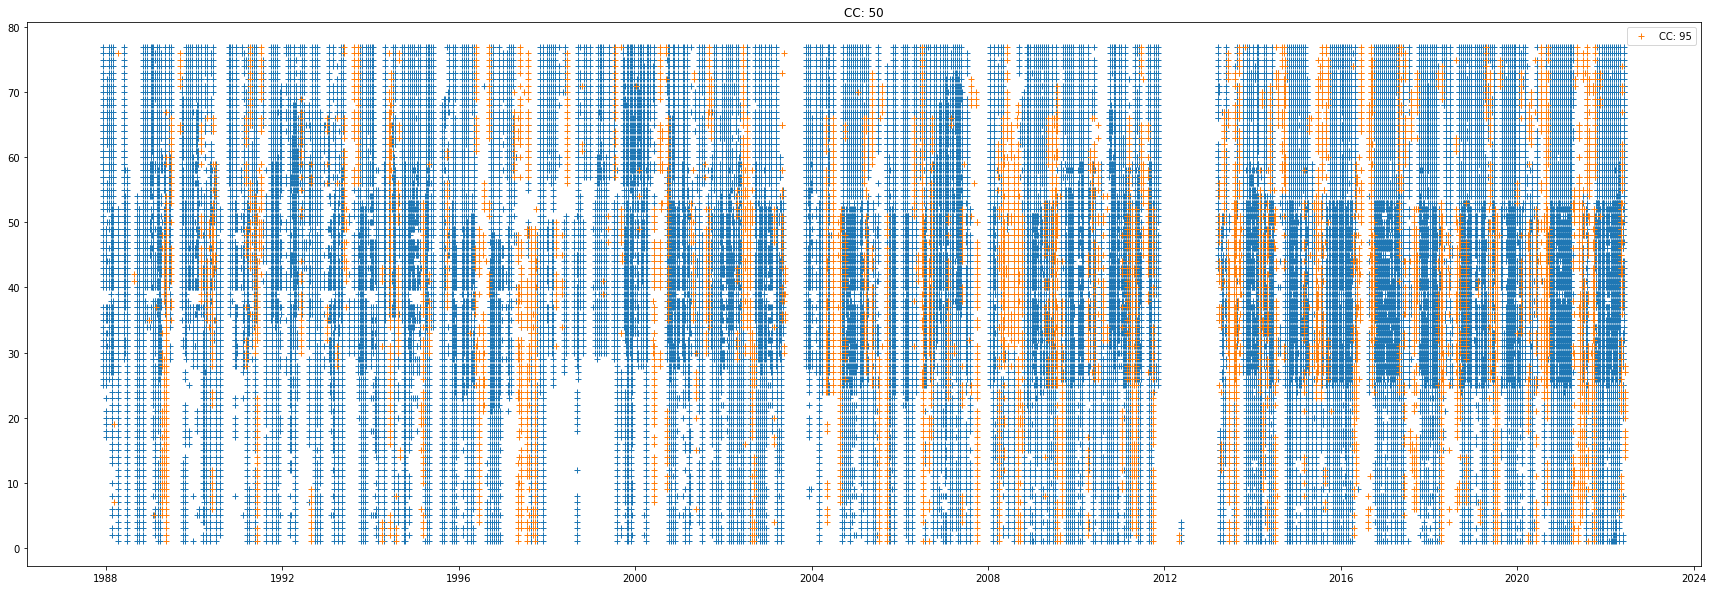

In [3]:
# Sparsity plot

# Barbara's opinion on CLOUD_FILTER
# - 
# - 

# GET DF100
# Work with reduced subset of DGOs.
# LOOK AT DATAPOINT OVERLAP

def plot_cc(name):
    df = pd.read_csv(f"Lhasa/Lhasa_Data-CC-{name}.csv", index_col=0);
    df["SENSING_TIME"] = df["SENSING_TIME"].map(pd.Timestamp);
    df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000;
    data = df; #df[["ID", "SENSING_TIME"]];
    plt.figure(figsize=(30, 10));
    plt.title(f"CC: {name}");
    plt.plot(data["SENSING_TIME"], data["ID"], '+');
    return data


df95 = plot_cc(95);

df80 = plot_cc(80);
df_diff = pd.concat([df95, df80]).drop_duplicates(keep=False);
plt.plot(df_diff["SENSING_TIME"], df_diff["ID"], '+', label="CC: 95");
plt.legend();

df50 = plot_cc(50);
df_diff = pd.concat([df95, df50]).drop_duplicates(keep=False);
plt.plot(df_diff["SENSING_TIME"], df_diff["ID"], '+', label="CC: 95");
plt.legend();

# df_c = df[df["ID"] == 1].sort_values("SENSING_TIME");

In [4]:
# CUMULATIVE GCD --- try to figure out & find the smallest spacing interval

a = (df95[df95['ID'] == 5]['SENSING_TIME']
 .sort_values().diff()[1:]
 .map(lambda t: t.days)
 .reset_index(drop=True))

print(a)
# GCD at each stage
last_gcd = a[0]
gcd_pairs = [(0, a[0])];
for k, v in enumerate(a[1:]):
    cur_gcd = np.gcd(last_gcd, v);
    if(cur_gcd != last_gcd):
        gcd_pairs.append((k+1, cur_gcd))
    last_gcd = cur_gcd
print(gcd_pairs)

0      48
1      80
2      80
3      16
4      32
       ..
317    32
318    16
319    16
320    32
321    16
Name: SENSING_TIME, Length: 322, dtype: int64
[(0, 48), (1, 16), (5, 8), (209, 2)]


(77, 788)


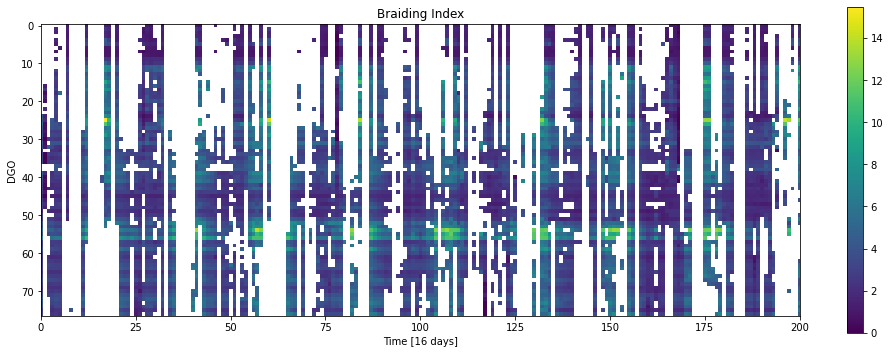

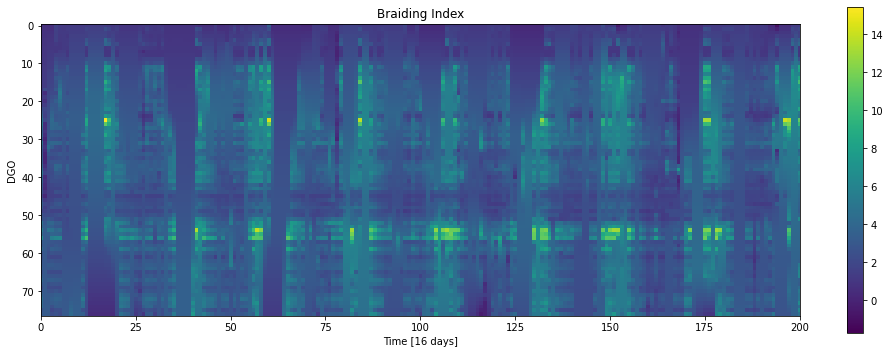

In [16]:
# Actually perform fitting...
df = df95.copy()
df = df.groupby(["ID", "SENSING_TIME"]).mean().reset_index()

d = 16;

# ONLY (Discuss) binning before/after -- effect on modifying Chambolle-Pock

df["t"] = (df["SENSING_TIME"] - df["SENSING_TIME"].min()).map(lambda t: t.days // d).astype(int);
df["x"] = df["ID"] - df["ID"].min().astype(int);

df = df.groupby(["x", "t"]).mean().reset_index()

Z = np.full((df["x"].max()+1, df["t"].max()+1), np.nan);
print(Z.shape)
for k, v in df[["x", "t", "BRAIDING_INDEX"]].iterrows():
    x = v["x"].astype(int);
    t = v["t"].astype(int);
    Z[x, t] = v["BRAIDING_INDEX"];
# TODO: PRESERVE MULTIPLICITY INFORMATION! ALSO TILE INDEX
# ALWAYS BE ABLE TO WORK BACKWARDS TO TILE ID FROM IMAGE
    
plt.figure(figsize=(17, 6));
plt.imshow(Z, interpolation='none');
plt.xlim([0, 200]);
plt.colorbar();
plt.xlabel(f'Time [{d} days]');
plt.ylabel('DGO');
plt.title('Braiding Index');

xt_data = Z.copy()
mask = np.ones(xt_data.shape);
mask[np.isnan(xt_data)] = 0;
xt_data[np.isnan(xt_data)] = 0;

sigma = 0.05
tau = 0.99/(1 + 4*sigma);
xt_cp, *_ = ChambollePockDenoisingTVinpainting(xt_data, mask,
    lamb=np.array([0.001, 0.05]),
    tau=tau,sigma=sigma,Niter=5000)
plt.figure(figsize=(17, 6));
plt.imshow(xt_cp);
plt.xlim([0, 200]);
plt.colorbar();
plt.xlabel(f'Time [{d} days]');
plt.ylabel('DGO');
plt.title('Braiding Index');

# 1)
# Validation of CC - Play with FIRST (100)
# PLAY WITH SECOND CC THRESHOLD ACROSS RANGE (DGO) [3 values]

# 2) Change INPUT --> Sentinel
# TRY TO MAKE CHAMBOLLE POCK LANDSAT DATA APPROACH SENTINEL DATA. (DOES INTERPOLATION WORK?)
# ALSO APPLY CHAMBOLLE POCK TO SENTINEL DATA (HOW SIMILAR ARE OUR RESULTS --- IS WHAT WE'RE DOING EVEN CORRECT?)

# 3)
# CHAMPOLLE POCK RESULTS
# SAVE RESULTS AS FETS FILE --> matlab plots...
# For NELLY

# 4) (Friday: Meeting with Barbara)
# VALIDATION OF FITTED DATA TO GROUND TRUTH --- HOW IS THE FIELD WORK DONE
# WE CAN DO THIS (EXPERT OPINION BASED)
# LOOK AT INDIVIDUAL POINTS --- THINK RANDOM SAMPLING HYPOTHESIS TESTING(????)